# Import Liberaries 

In [25]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
import os
from imgaug import augmenters as iaa
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,Conv2D,MaxPooling2D,GlobalAveragePooling2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


# Connect to My google drive

In [2]:
# Load the Drive helper and mount

from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


# Read Data 

images for 29 arabic character in different position in sentence

data link : https://github.com/HusseinYoussef/Arabic-OCR/tree/master/Dataset

In [26]:
labels=[u'ا',u'ب',u'ت',u'ث',u'ج',u'ح',u'خ',u'د',u'ذ',u'ر',u'ز',u'س',u'ش',u'ص',u'ض',u'ط',u'ظ',u'ع',u'غ',u'ف',u'ق',u'ك',u'ل',u'لا',u'م',u'ن',u'ه',u'و',u'ي']

In [27]:
images = []
y=[]
def load_images_from_folder(folder,label):   
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            y.append(label)
    return images

In [28]:
for i in range(29):
    load_images_from_folder('/content/drive/My Drive/Arabic Handwritten Characters/charctaers_datasets/{}'.format(labels[i]),i)

In [29]:
print("Images Count : {} and labels count {}".format(len(images),len(y)))

Images Count : 39334 and labels count 39334


#Visualization 

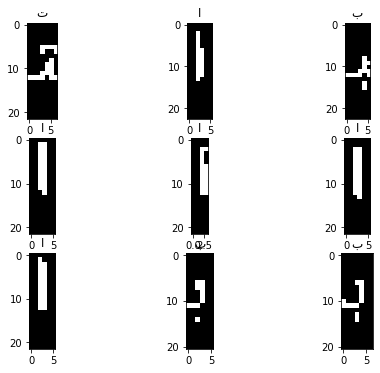

In [30]:
plt.figure(figsize=(8,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    ran_num=random.randint(0, 10000)
    plt.imshow(images[ran_num])
    plt.title(labels[y[ran_num]])
plt.show()

# Data Augmentation 

Text(0.5, 1.0, 'Zoomed In Image')

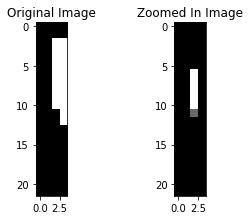

In [31]:
#Zoom image

def zoom_in (image):
  zoom=iaa.Affine(scale=(0.5,0.6))
  image=zoom.augment_image(image)
  return image 




#visualize  the agumenetd image
original_image = images[random.randint(0, 10000)].astype(np.uint8)
zoomed_image = zoom_in(original_image)

fig, axs = plt.subplots(1, 2, figsize=(4, 3))
fig.tight_layout()

axs[0].imshow(original_image,cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image,cmap='gray')
axs[1].set_title('Zoomed In Image')




Text(0.5, 1.0, 'Zoomed out Image')

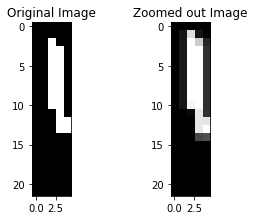

In [32]:
#Zoom image

def zoom_out(image):
  zoom=iaa.Affine(scale=(1.1,1.1))
  image=zoom.augment_image(image)
  return image 




#visualize  the agumenetd image
original_image = images[random.randint(0, 10000)].astype(np.uint8)
zoomed_image = zoom_out(original_image)

fig, axs = plt.subplots(1, 2, figsize=(4, 3))
fig.tight_layout()

axs[0].imshow(original_image,cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image,cmap='gray')
axs[1].set_title('Zoomed out Image')




In [33]:
#Augmentation function 

def agumented_image(image,label):
  if np.random.rand()<0.5:
    image=zoom_in(image)
  if np.random.rand()<0.5:
    image=zoom_out(image)
  return image,label

## Visualize  agumented images

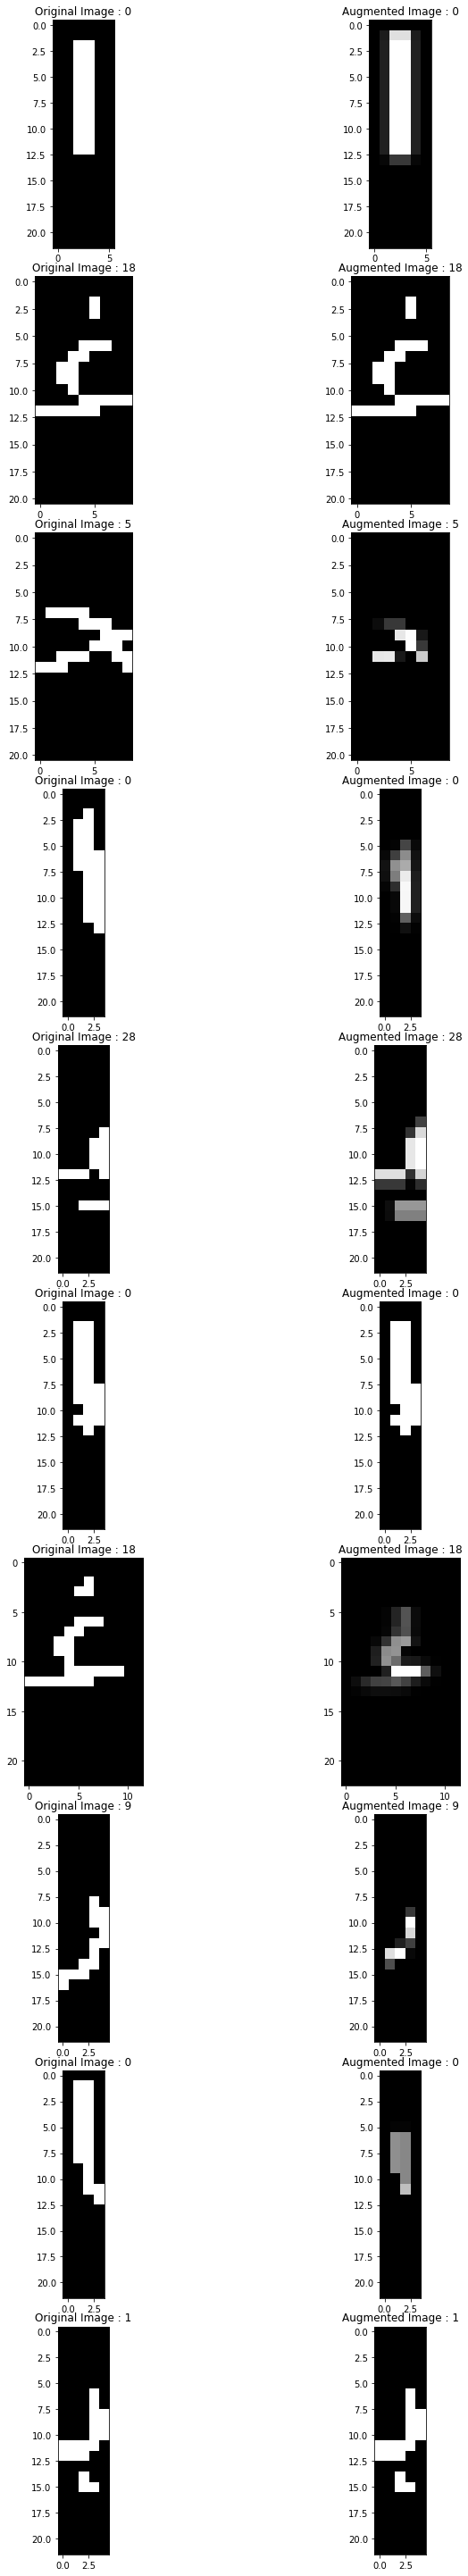

In [34]:
#visualize the agumented images 
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize=(10, 40))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(images) - 1)
  original_image = images[randnum].astype(np.uint8)
    
  augmented_image, label = agumented_image(original_image,y[randnum])
    
  axs[i][0].imshow(original_image,cmap='gray')
  axs[i][0].set_title("Original Image : "+ str(label))
  
  axs[i][1].imshow(augmented_image,cmap='gray')
  axs[i][1].set_title("Augmented Image : " +str(label ))

#### Know mean size of images to reshape it


In [35]:
dim1=[]
dim2=[]
for image in images:
    d1,d2,colors=image.shape
    dim1.append(d1)
    dim2.append(d2)

In [36]:
print(np.mean(dim1),np.mean(dim2))


22.247317842070473 8.809681191844206


#Image PreProcessing

In [37]:
def image_preprocessing(image):
    image=image.astype(np.uint8)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image=image/255
    img=cv2.resize(image,(28,20))
    return img

In [38]:
images=[image_preprocessing(image) for image in images ]
images=np.array(images)

In [39]:
print("y  shape :",np.array(y).shape)


y  shape : (39334,)


convert shape of label 

In [40]:
y=to_categorical(np.array(y))
y.shape

(39334, 29)

Split Images To train and test 

In [41]:
from sklearn.model_selection import train_test_split
X_train,X_test,train_y,test_y=train_test_split(images,y,test_size=0.1,shuffle=True) #train 90% and test 10%

In [42]:
X_train=X_train.reshape(X_train.shape[0],28,20,1)
X_test=X_test.reshape(X_test.shape[0],28,20,1)

print("Training Images Shape : ", X_train.shape)
print("Testing Images Shape : ",X_test.shape)

Training Images Shape :  (35400, 28, 20, 1)
Testing Images Shape :  (3934, 28, 20, 1)


Build Batch  generatot 

In [43]:
def batch_generator (images,labels,batch_size,istraining):
  while True:
    batch_img = []
    batch_label = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(images) - 1)
      
      if istraining:
        image, label = agumented_image(images[random_index].reshape(28,20).astype(np.uint8), labels[random_index])
     
      else:
        image = images[random_index]
        label = labels[random_index]
      
      batch_img.append(image.reshape(32,32,1))
      batch_label.append(label)
    yield (np.array(batch_img), np.array(batch_label)) 
      


# Define Model 

In [44]:
num_classes=29

def create_model():
  model=Sequential()
  model.add(Conv2D(30,(3,3),input_shape=(28,20,1),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(60,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(50,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes,activation='softmax'))
  model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy'])
  return model


In [45]:
model=create_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 18, 30)        300       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 9, 30)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 7, 60)         16260     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 3, 60)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 900)               0         
                                                                 
 dense (Dense)               (None, 50)                4

Train Model 

In [46]:
history =model.fit_generator(batch_generator(X_train, train_y, 128, 1),
                                  steps_per_epoch=294, 
                                  epochs=300,
                                  validation_data=batch_generator(X_train, train_y, 32, 0),
                                  validation_steps=100,
                                  verbose=1,
                                  shuffle = 1)


Epoch 1/30
249/249 [==============================] - 16s 63ms/step - loss: 2.0238 - accuracy: 0.4259 - val_loss: 0.7923 - val_accuracy: 0.7946
Epoch 2/30
249/249 [==============================] - 16s 64ms/step - loss: 1.0460 - accuracy: 0.6565 - val_loss: 0.4288 - val_accuracy: 0.8777
Epoch 3/30
249/249 [==============================] - 16s 65ms/step - loss: 0.8168 - accuracy: 0.7209 - val_loss: 0.3261 - val_accuracy: 0.9025
Epoch 4/30
249/249 [==============================] - 16s 63ms/step - loss: 0.6977 - accuracy: 0.7598 - val_loss: 0.2708 - val_accuracy: 0.9243
Epoch 5/30
249/249 [==============================] - 15s 62ms/step - loss: 0.6253 - accuracy: 0.7829 - val_loss: 0.2284 - val_accuracy: 0.9328
Epoch 6/30
249/249 [==============================] - 15s 62ms/step - loss: 0.5837 - accuracy: 0.7950 - val_loss: 0.1966 - val_accuracy: 0.9393
Epoch 7/30
249/249 [==============================] - 15s 61ms/step - loss: 0.5435 - accuracy: 0.8044 - val_loss: 0.1798 - val_accuracy:

### Visualize Loss and Accuarcy 

Text(0.5, 0, 'epochs')

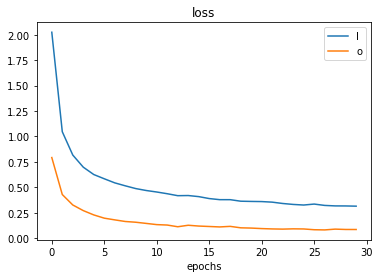

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend('loss')
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

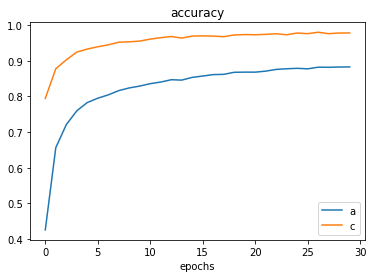

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.legend('accuracy')
plt.xlabel('epochs')

### evaluate the model 

In [50]:
score =model.evaluate(X_test,test_y)
print('Test score ' ,score[0])
print('Test accuracy ', score[1])

123/123 [==============================] - 1s 6ms/step - loss: 0.1296 - accuracy: 0.9725
Test score  0.1295790672302246
Test accuracy  0.9725470542907715


### Save Model

In [66]:
model.save('/content/drive/My Drive/COELIA/Ar_ch_model_edition2.h5')

In [67]:
model = tf.keras.models.load_model('/content/drive/My Drive/COELIA/Ar_ch_model_edition2.h5')

In [68]:
score =model.evaluate(X_test,test_y)
print('Test score ' ,score[0])
print('Test accuracy ', score[1])

123/123 [==============================] - 1s 6ms/step - loss: 0.1296 - accuracy: 0.9725
Test score  0.1295790672302246
Test accuracy  0.9725470542907715


# Make Prediction 

In [51]:
# Define List of charcters 
result=[u'أ',u'ب',u'ت',u'ث',u'ج',u'ح',u'خ',u'د',u'ذ',u'ر',u'ز',u'س',u'ش',u'ص',u'ض'u'ط',u'ظ',u'ع',u'غ',u'ف',u'ق',
        u'ك',u'ل',u'م',u'ن',u'ه',u'و',u'ي']

Text(0.5, 1.0, 'ت')

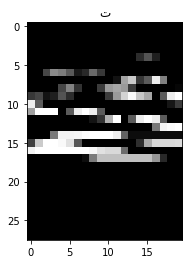

In [56]:
plt.figure(figsize=(6,4))
plt.imshow(X_test[0].reshape(28,20),cmap='gray')
plt.title(result[test_y[0].argmax(axis=0)])

In [58]:
print("Acual value : ",result[test_y[0].argmax(axis=0)]," and prediction : " , result[model.predict(X_test[0].reshape(-1,28,20,1)).argmax(axis=1)[0]])

Acual value :  ت  and prediction :  ت


Text(0.5, 1.0, 'ب')

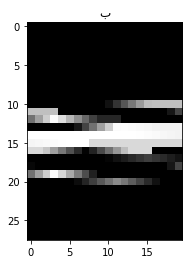

In [59]:
plt.figure(figsize=(6,4))
plt.imshow(X_test[2].reshape(28,20,),cmap='gray')
plt.title(result[test_y[2].argmax(axis=0)])

In [60]:
print("Acual value : ",result[test_y[2].argmax(axis=0)]," and prediction : " , result[model.predict(X_test[2].reshape(-1,28,20,1)).argmax(axis=1)[0]])

Acual value :  ب  and prediction :  ب


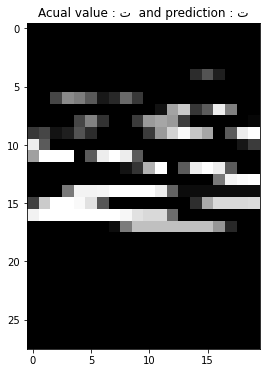

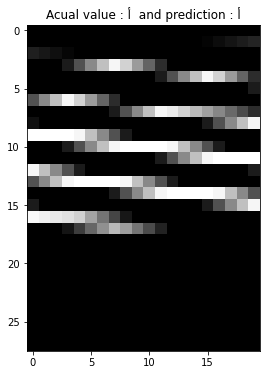

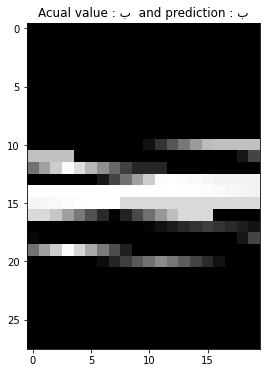

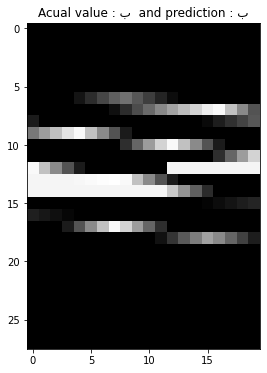

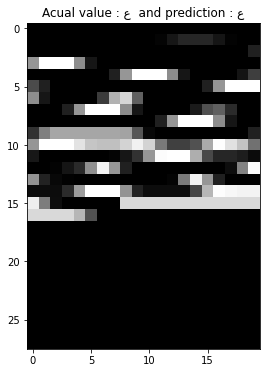

In [62]:
for i in range(5):
    plt.figure(figsize=(8,6))
    plt.imshow(X_test[i].reshape(28,20),cmap='gray')
    plt.title("Acual value : {}  and prediction : {}".format(result[test_y[i].argmax(axis=0)], result[model.predict(X_test[i].reshape(-1,28,20,1)).argmax(axis=1)[0]]))

Method To Make Prediction 

In [63]:
def make_prediction(image):
    if image.ndim==3 and image.shape[2]==1 or image.ndim==2 :
        image=cv2.resize(image,(28,20))
        image=image/255
        image=image.reshape(-1,28,20,1)
        print("Prediction :  " ,result[model.predict(image).argmax(axis=1)[0]])
    else:
        image=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image=cv2.resize(image,(28,20))
        image=image/255
        image=image.reshape(-1,28,20,1)
        print("Prediction :  " ,result[model.predict(image).argmax(axis=1)[0]])

make_prediction(X_test[0])

Prediction :   ب


In [64]:
make_prediction(X_test[0].reshape(28,20,1))

Prediction :   ب


Method Take image as input

In [65]:
def predict_charcter_in_image(image):
    image=cv2.imread(image,0) # 0 in flage to convert image to gray scale 
    image=cv2.resize(image,(28,20))
    image=image/255
    image=image.reshape(-1,28,20,1)
    print("Prediction :  " ,result[model.predict(image).argmax(axis=1)[0]])